# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

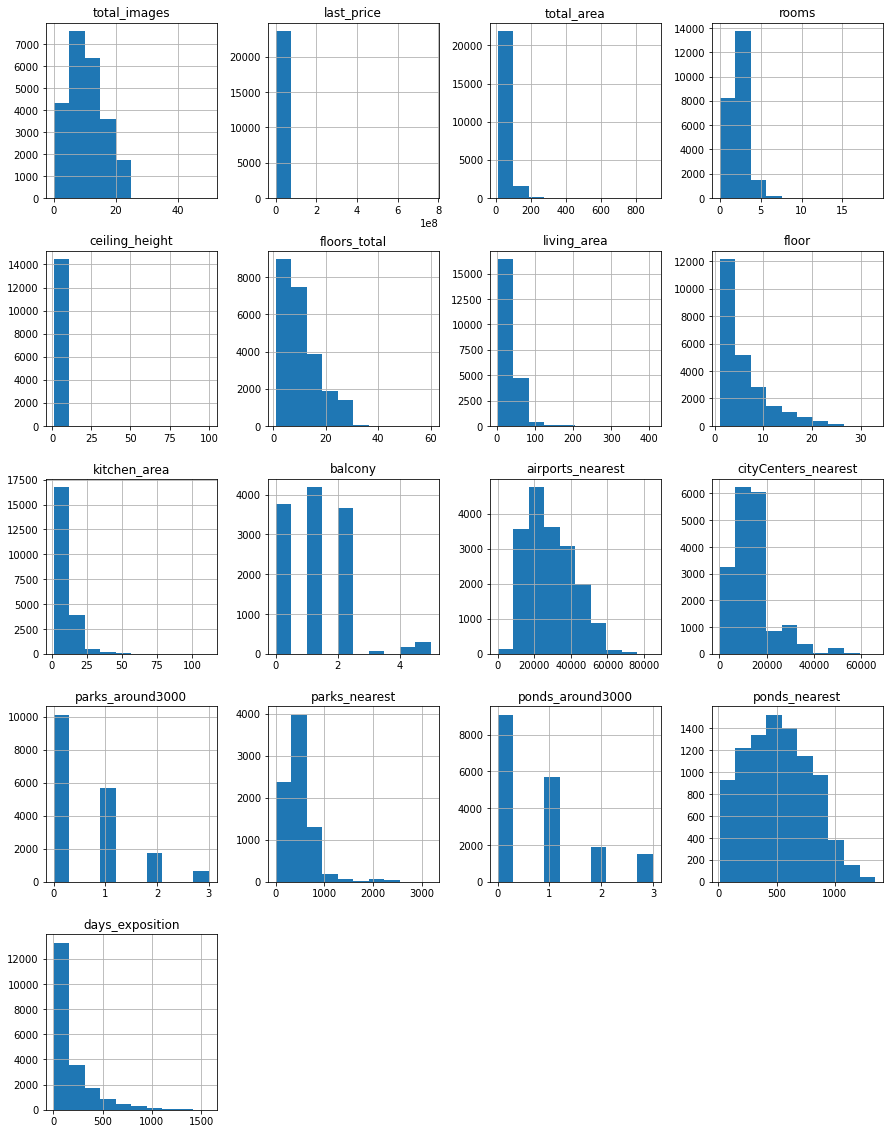

In [13]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
print(data.head(5))
data.hist(figsize=(15,20))

### Предобработка данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  object 
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

<AxesSubplot:>

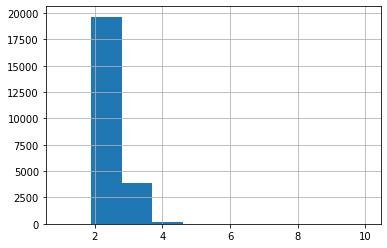

In [14]:
# ищем пропущенные значения
data.isna().sum()
# замена пропусков в столбце is_apartment (заменяем на False, т.к. квартира либо относится к апартаментам, либо нет. 
#если изначально не соотнесли квартиру с апартаментами, то скорее всего она к ним не относится. Поэтому False)
data['is_apartment'] = data['is_apartment'].fillna(value = 'False')
data.isna().sum()

# заменим пропущенные значения для balcony, parks_around3000, ponds_around3000 на 0 (если значения в этих столбцах не указаны, то, вероятно, балконов, пакрков и прудов нет)
columns_for_replace = ['balcony', 'parks_around3000', 'ponds_around3000']
for value_for_replace in columns_for_replace:
    data[value_for_replace] = data[value_for_replace].fillna('0')
# замена пустых значений столбцов kitchen_area, living_area, floors_total, ceiling_height:
data=data.fillna({'kitchen_area':data['kitchen_area'].median()})
data=data.fillna({'living_area':data['living_area'].median()})
data=data.fillna({'floors_total':data['floors_total'].median()})
data=data.fillna({'ceiling_height':data['ceiling_height'].median()})
data=data.fillna({'days_exposition':data['days_exposition'].median()})
data.isna().sum()
# смотрим на типы данных столбцов:
data.info()
# меняем тип данных в выбранных столбцах
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
#анализ столбца на предмет уникальных значений
data['locality_name'].unique()
# устранение неявных дубликатов
data['locality_name']=data['locality_name'].str.replace('ё','е')
data['locality_name']=data['locality_name'].str.replace('поселок городского типа','поселок')
data['locality_name']=data['locality_name'].str.replace('коттеджный поселок','поселок')
data['locality_name']=data['locality_name'].str.replace('садовое товарищество','поселок')
data['locality_name']=data['locality_name'].str.replace('городской поселок','поселок')
# изучение столбца ceiling_height:
data['ceiling_height'].describe()
data['ceiling_height'].unique()
# функия для удаления значений высоты потолков свыше 10 метров
def c_h_correct (row):
    if row > 10:
        row = row/10
    return row
data['ceiling_height'] = data['ceiling_height'].apply(c_h_correct)
data['ceiling_height'].unique()
data['ceiling_height'].hist()







(0.0, 11.0)

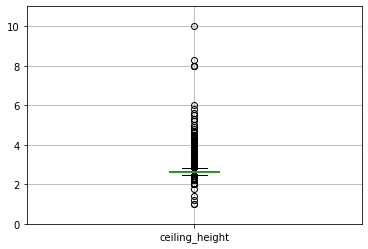

In [15]:
data.boxplot(column=['ceiling_height'])
plt.ylim(0,11)


In [16]:
#data['ceiling_height'].unique()
print(len(data['ceiling_height']))
#data = data.query ('2 <= ceiling_height <= 4')

23699


Значения за пределами квартилей можно рассматривать как выбросы и удалять из выборки. При удалении выбросов (квартир с потолками менее 2 и более 4 метров теряется 739 квартир (3,1% выборки), что допустимо. Однако в этом анализе удалять я эти квартиры не буду. Во первых, это уникальные объекты на рынке недвижимости. Цена на них, как и спрос определяется множеством факторов, здесь неучтенными (наличием/отсутствием необходимости титульного страхования, наличие рядом школ/детсадов и пр., исторической ценностью (в этом доме мог жить герой СССР) и пр.) Принято решение об оставлении квартир в анализе, тем более, что аномальные значения устранены функцией c_h_correct. 

В столбцах: locality_name, airports_nearest, cityCenters_nearest, parks_nearest,ponds_nearest,days_exposition
невозможно убрать пустые значения в силу уникальности значений этих столбцов (для их корректировки нужны доп. данные из иных датафреймов)
в стобцах: floors_total, parks_around3000, ponds_around3000 тип данных был изменен на int, т.к. значения в этих столбцах могут применять только целые  значения.

### Посчитайте и добавьте в таблицу новые столбцы

In [17]:
# добавление столбца со стоимостью 1 кв.м.
data['price_one_sq_m'] = data ['last_price'] / data ['total_area']
# добавление столбца с указанием дня недели
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')
#data['day_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).day
data['day_of week'] = data['first_day_exposition'].dt.dayofweek
data['month_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year
#функция определяющая тип этажа, вначале смотрим на самое большое значение
data['floor'].sort_values(ascending = False)
def type_of_floor (index):
    if index['floor'] <= 1:
        return 'первый этаж'
    elif index['floor'] == index['floors_total']:
        return 'последний этаж'
    else:
        return 'другой этаж'
data['t_of_floor'] = data[['floor', 'floors_total']].apply(type_of_floor, axis = 1)
# округляем расстояние до центра
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)
data = data.round({'cityCenters_nearest_km':1})
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_sq_m,day_of week,month_exposition,year_exposition,t_of_floor,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2,755.0,95.0,120370.370370,3,3,2019,другой этаж,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый этаж,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой этаж,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,30.0,9,False,...,84.0,3,234.0,424.0,408176.100629,4,7,2015,другой этаж,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой этаж,8.0


### Проведите исследовательский анализ данных

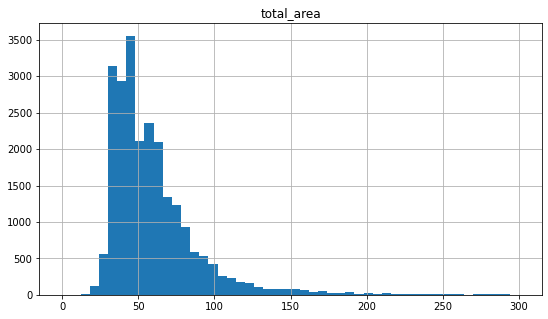

(0.0, 300.0)

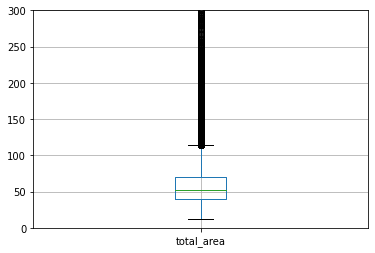

In [22]:
data.hist('total_area', grid = True, bins = 50, range = (0, 300), figsize = (9, 5))
plt.show()
data.boxplot(column=['total_area'])
plt.ylim(0,300)


Большая часть квартир продается с площадью до 200 кв.м. Наибольшей популярностью пользуются квартиры площадью от 50 до 100 кв.м. Видны выбросы - квартиры площадью свыше 100 кв.м.

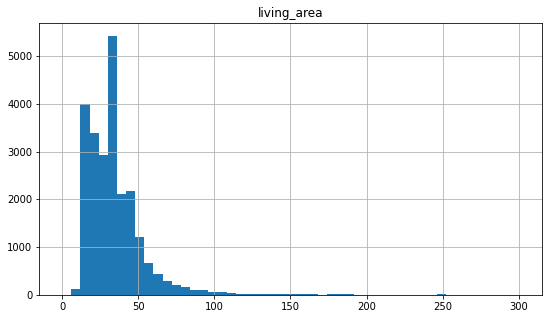

(0.0, 300.0)

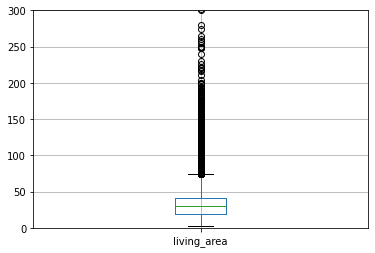

In [19]:
data.hist('living_area', grid = True, bins = 50, range = (0, 300), figsize = (9, 5))
plt.show()
data.boxplot(column=['living_area'])
plt.ylim(0,300)

Наблюдаются выбросы по параметру жилой площади. 

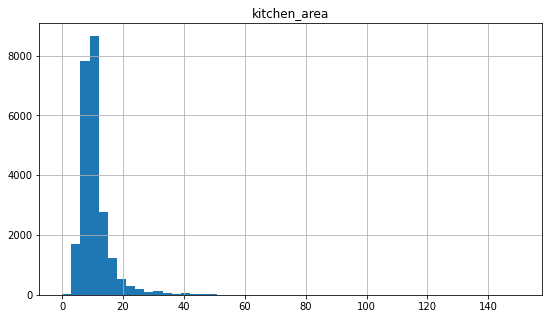

(0.0, 150.0)

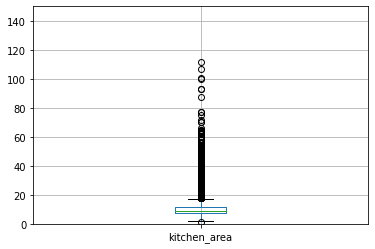

In [20]:
data.hist('kitchen_area', grid = True, bins = 50, range = (0, 150), figsize = (9, 5))
plt.show()
data.boxplot(column=['kitchen_area'])
plt.ylim(0,150)

Наиболее часто встречающееся значение по площади кухонь - 15-17 вк.м. Есть уникальные значения с площадью кухни за 30 кв.м. (например 100 кв.м.)

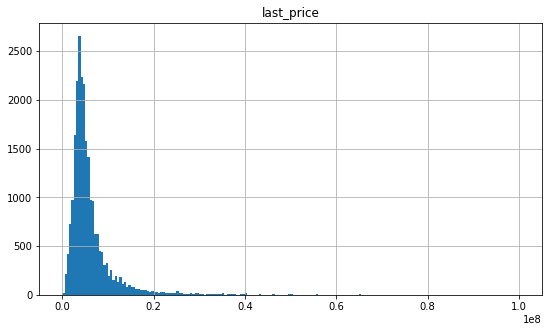

(0.0, 100000000.0)

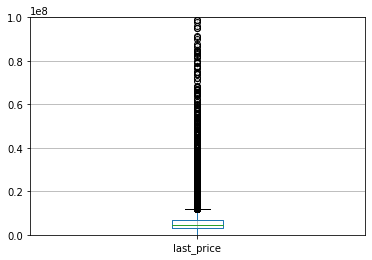

In [21]:
data.hist('last_price', grid = True, bins = 200, range = (0, 100000000), figsize = (9, 5))
plt.show()
data.boxplot(column=['last_price'])
plt.ylim(0,100000000)

Большая часть квартир стоит в пределах 2 млн.у.е. Выбросы есть на уникальные объекты

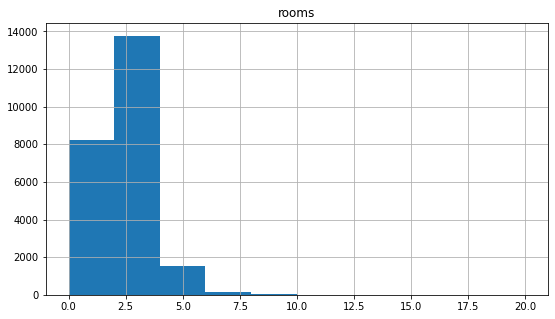

(0.0, 20.0)

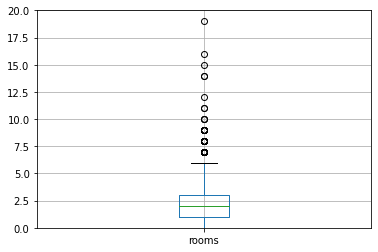

In [23]:
data.hist('rooms', grid = True, bins = 10, range = (0, 20), figsize = (9, 5))
plt.show()
data.boxplot(column=['rooms'])
plt.ylim(0,20)


Большая часть объявлений - 2-3 комнатые квартиры. Есть объявления с количеством комнат свыше 15

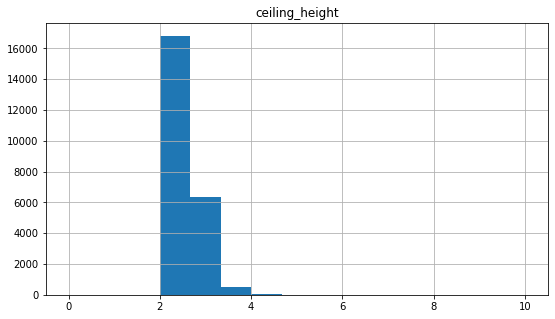

(0.0, 20.0)

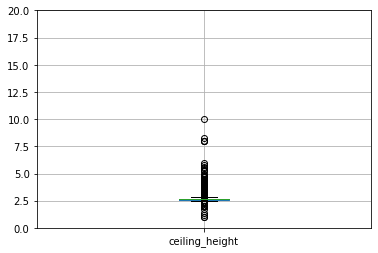

In [24]:
data.hist('ceiling_height', grid = True, bins = 15, range = (0, 10), figsize = (9, 5))
plt.show()
data.boxplot(column=['ceiling_height'])
plt.ylim(0,20)

Есть выбросы и до 2 м потолков и свыше 4 метров. Большая часть квартир - от 2 до 4 метров

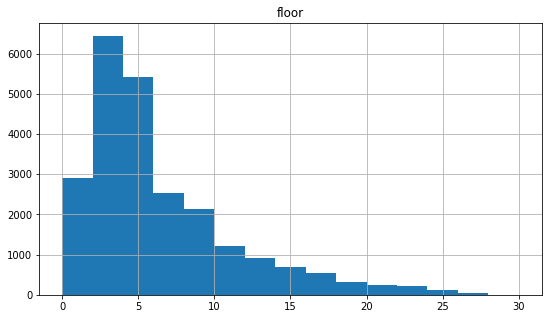

(0.0, 30.0)

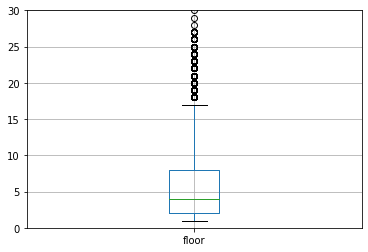

In [25]:
data.hist('floor', grid = True, bins = 15, range = (0, 30), figsize = (9, 5))
plt.show()
data.boxplot(column=['floor'])
plt.ylim(0,30)

Чаще выставляются на продажу квартиры до 15-20 этажей.

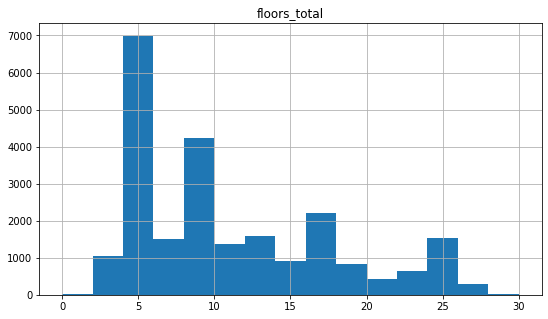

(0.0, 30.0)

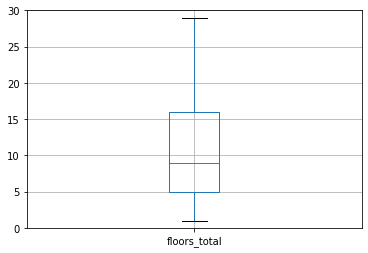

In [26]:
data.hist('floors_total', grid = True, bins = 15, range = (0, 30), figsize = (9, 5))
plt.show()
data.boxplot(column=['floors_total'])
plt.ylim(0,30)

Выбросов нет. Больше всего предложений о продаже квартир в 5-ти и 10-ти этажных домах.

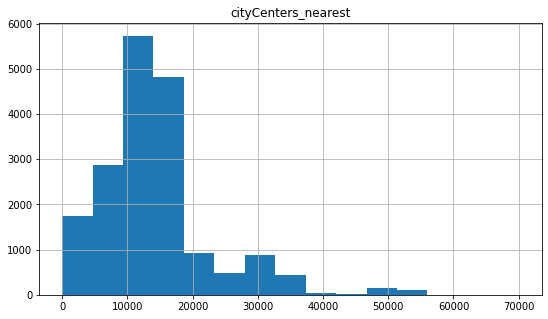

(0.0, 70000.0)

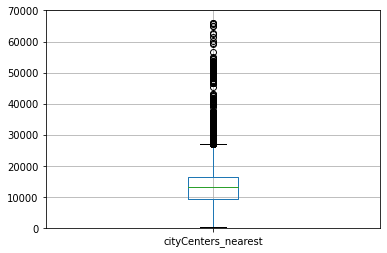

In [27]:
data.hist('cityCenters_nearest', grid = True, bins = 15, range = (0, 70000), figsize = (9, 5))
plt.show()
data.boxplot(column=['cityCenters_nearest'])
plt.ylim(0,70000)

Большая часть квартир продается в районе 20 км. от центра города

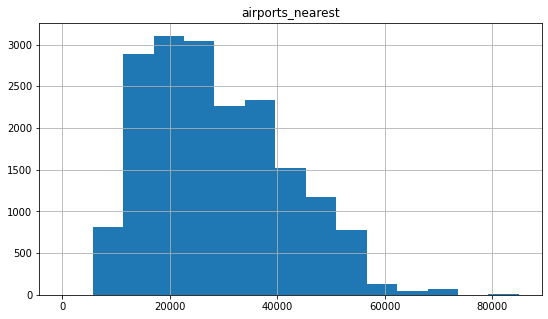

(0.0, 70000.0)

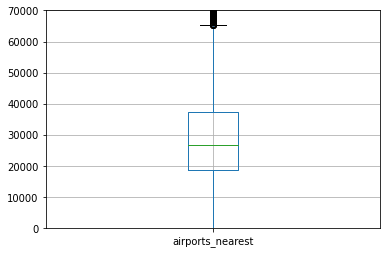

In [36]:
data.hist('airports_nearest', grid = True, bins = 15, range = (0, 85000), figsize = (9, 5))
plt.show()
data.boxplot(column=['airports_nearest'])
plt.ylim(0,70000)

Квартиры, находящиеся на расстоянии свыше 60 000 метров от аэропорта меньше выставляются на продажу

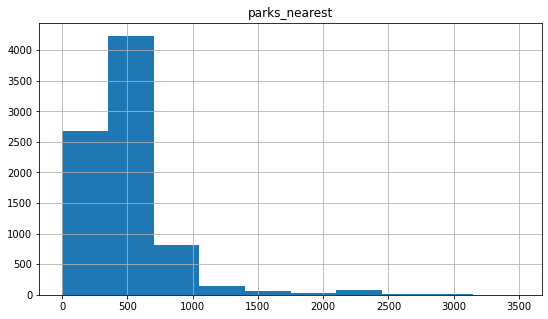

(0.0, 1000.0)

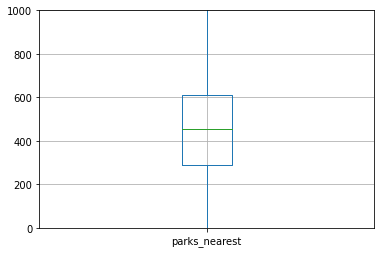

In [38]:
data.hist('parks_nearest', grid = True, bins = 10, range = (0, 3500), figsize = (9, 5))
plt.show()
data.boxplot(column=['parks_nearest'])
plt.ylim(0,1000)

Большая часть продаваемых квартир в припарковой зоне

(array([17441.,  2917.,  3341.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

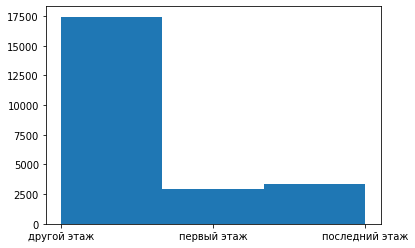

In [40]:
plt.hist(data['t_of_floor'], bins = 3)

<AxesSubplot:xlabel='t_of_floor'>

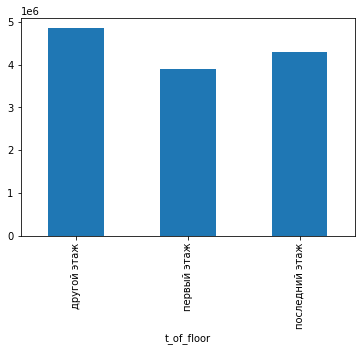

In [28]:
data.groupby('t_of_floor')['last_price'].median().plot.bar()

Наиболее дорогие квартиры - между первым и последним этажами. Они и лидируют в количестве распроданных квартир

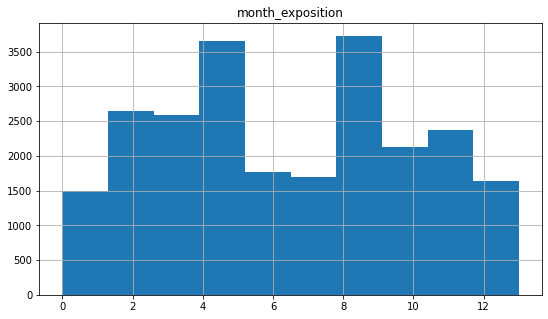

(0.0, 13.0)

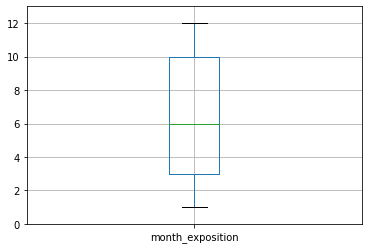

In [42]:
data.hist('month_exposition', grid = True, bins = 10, range = (0, 13), figsize = (9, 5))
plt.show()
data.boxplot(column=['month_exposition'])
plt.ylim(0,13)

Летом и зимой наблюдается затишье в выставлении объявлений о продаже квартир. Чаще всего объявления вывешвают в мае и сентябре.

медиана, 95.0
среднее, 169.36022616988058


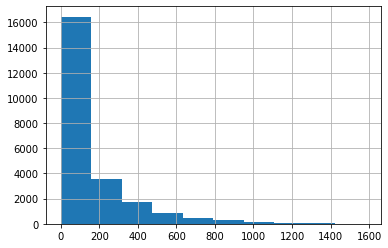

In [29]:
data['days_exposition']. hist()
print(f"медиана, {data['days_exposition'].median()}")
print(f"среднее, {data['days_exposition'].mean()}")

В среднем квартиры продаются за 169 дней. Наиболее ликвидные квартиры продаются за период чуть больше квартала.

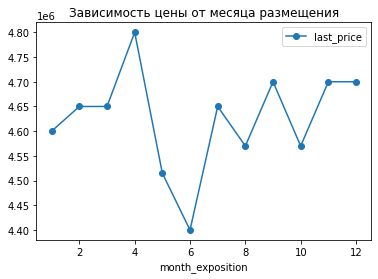

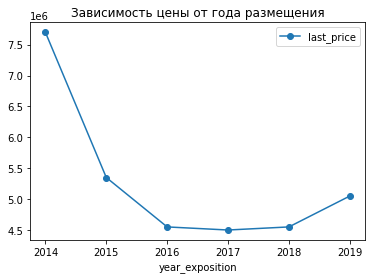

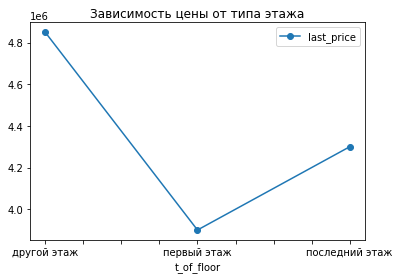

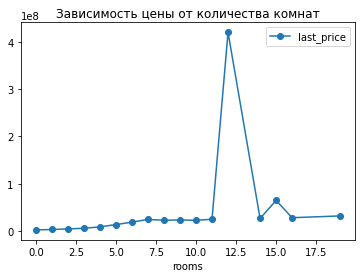

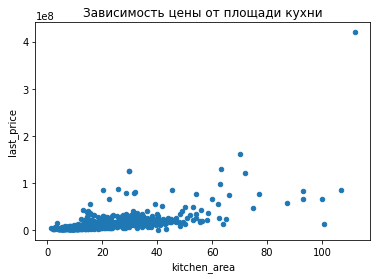

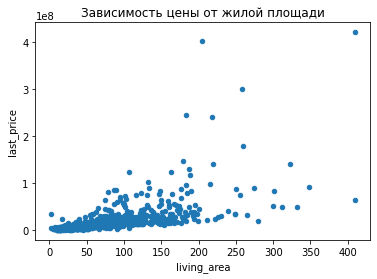

<AxesSubplot:title={'center':'Зависимость цены от общей площади'}, xlabel='total_area', ylabel='last_price'>

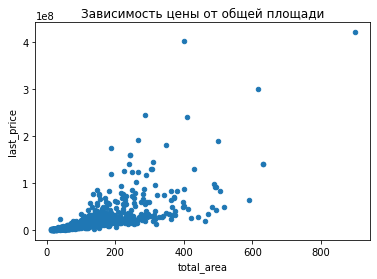

In [30]:
#зависимость цены от дат публикации объявления
data.pivot_table(index='month_exposition', values='last_price', aggfunc='median').plot(style='o-', title='Зависимость цены от месяца размещения')
plt.show()
data.pivot_table(index='year_exposition', values='last_price', aggfunc='median').plot(style='o-', title='Зависимость цены от года размещения')
plt.show()
data.pivot_table(index='t_of_floor', values='last_price', aggfunc='median').plot(style='o-', title='Зависимость цены от типа этажа')
plt.show()
data.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(style='o-', title='Зависимость цены от количества комнат')
plt.show()
data.pivot_table(index='kitchen_area', values='last_price', aggfunc='median').reset_index().plot(title='Зависимость цены от площади кухни', x = 'kitchen_area', y = 'last_price', kind = 'scatter')
plt.show()
data.pivot_table(index='living_area', values='last_price', aggfunc='median').reset_index().plot(title='Зависимость цены от жилой площади', x = 'living_area', y = 'last_price', kind = 'scatter')
plt.show()
data.pivot_table(index='total_area', values='last_price', aggfunc='median').reset_index().plot(title='Зависимость цены от общей площади', x = 'total_area', y = 'last_price', kind = 'scatter')

In [31]:
#Расчет коэффициента корреляции Пирсона (цены от общей площади)
print(data['total_area'].corr(data['last_price']))
#Расчет коэффициента корреляции Пирсона (цены от жилой площади)
print(data['living_area'].corr(data['last_price']))
#Расчет коэффициента корреляции Пирсона (цены от площади кухни)
print(data['kitchen_area'].corr(data['last_price']))
#Расчет коэффициента корреляции Пирсона (цены от количества комнат)
print(data['rooms'].corr(data['last_price']))
#Расчет коэффициента корреляции Пирсона (цены от года размещения)
print(data['year_exposition'].corr(data['last_price']))
#Расчет коэффициента корреляции Пирсона (цены от месяца размещения)
print(data['month_exposition'].corr(data['last_price']))
#Расчет коэффициента корреляции Пирсона (цены от типа этажа)
print(data['floor'].corr(data['last_price']))



0.6536750579657242
0.5406588415034878
0.44031561243446554
0.3633428499648948
-0.043089036199508615
0.0027791287507397166
0.026575643284470797


Среди исследуемых параметров, наибольшая прямая зависимость цены наблюдается от изменения в большую сторону общей площади квартиры. Причем это характерно для квартир с площадью до 200 кв.м. Меньшее влияние на цену оказывает изменение площади кухни (хотя с кухнями до 50 кв.м. наблюдается положительая корреляция),количества комнат, месяц размещения. По корреляци цены с годом размещения видна обратная тенденция к снижению цены от последующих размещенных объявлений, связь довольна слабая.


Цены на квартиры выше при размещении объявлении о продаже осенью и в зимние месяцы. С 2014 года наблюдается снижение цен на недвижимость. Квартиры не на последнем и первых этажах стоят больше. Квартиры с большой кухней стоят дороже, однако эта зависимость характерна для жилья с большой общей площадью. Наиболее дорогие квартиры от 170 до 255 кв.м. жилой площади. Есть также и дорогое элитное жилье с общей площадью свыше 400 кв.м. 

In [32]:
top_ten = data['locality_name'].value_counts().head(10) 
top_m_price = data.query('locality_name in (@top_ten.index)').pivot_table(values='price_one_sq_m', index='locality_name')
top_m_price = top_m_price.astype(int)
top_m_price.sort_values('price_one_sq_m', ascending = False)



                                                                          

,price_one_sq_m
locality_name,
Санкт-Петербург,114849
Пушкин,103125
деревня Кудрово,92473
поселок Парголово,90175
поселок Мурино,85681
поселок Шушары,78677
Колпино,75424
Гатчина,68746
Всеволожск,68654


[Text(0, 0, 'Санкт-Петербург'),
 Text(1, 0, 'поселок Мурино'),
 Text(2, 0, 'поселок Шушары'),
 Text(3, 0, 'Всеволожск'),
 Text(4, 0, 'Пушкин'),
 Text(5, 0, 'Колпино'),
 Text(6, 0, 'поселок Парголово'),
 Text(7, 0, 'Гатчина'),
 Text(8, 0, 'деревня Кудрово'),
 Text(9, 0, 'Выборг')]

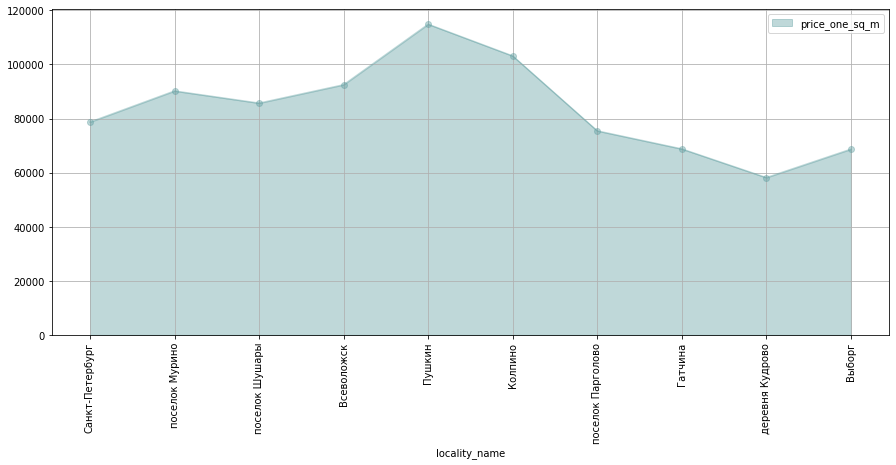

In [33]:
ax =(data.query('locality_name in (@top_ten.index)').pivot_table(values='price_one_sq_m', index='locality_name').sort_values(by='locality_name', ascending=False)).plot(grid=True, kind='area', style='o-', color='cadetblue', alpha=0.4, figsize = (15, 6))
ax.set_xticks(list(range(len(top_ten.index.tolist()))))
ax.set_xticklabels(top_ten.index.tolist(), rotation=90)

Населенный пункт с самой высокой стоимостью  1 кв. м. среди тех, кто больше всех размещает объявления - в Санкт-Петербурге (114613), с самой низкой стоимостью 1 кв.м. - в Выборге (58093)

In [34]:
data_spb = data.query('locality_name == "Санкт-Петербург"')
data_spb = data.pivot_table(index='cityCenters_nearest', values = 'price_one_sq_m', aggfunc='median')
data_spb.head(10)


,price_one_sq_m
cityCenters_nearest,
181.0,195591.194969
208.0,172619.047619
215.0,109900.000000
287.0,88796.296296
291.0,101321.585903
318.0,454375.000000
329.0,100000.000000
376.0,137755.102041
387.0,139318.885449


<AxesSubplot:title={'center':'Зависимость цены от расстояния до центра'}, xlabel='cityCenters_nearest', ylabel='price_one_sq_m'>

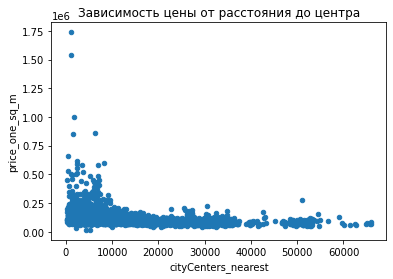

In [35]:
data_spb.pivot_table(index='cityCenters_nearest', values='price_one_sq_m', aggfunc='median').reset_index().plot(title='Зависимость цены от расстояния до центра', x = 'cityCenters_nearest', y = 'price_one_sq_m', kind = 'scatter')

С удалением от центра города уменьшается стоимость 1 кв.м. недвижимости и подобных объявлений становится меньше

### Общий вывод

Для достижения целей проекта (поиск интересных особенностей и зависимостей, которые существуют на рынке недвижимости) была выполнена предобработка данных. 

На этапе предобработки данных было определено:

1.1. Наличие пустых значений в графах: 
- kitchen_area
- living_area
- floors_total
- ceiling_height
- days_exposition

Пустые значения были заполнены медианными значениями соответствующих столбцов

1.2. Были произведены замены пропущенных значений для граф: balcony, parks_around3000, ponds_around3000 на 0 (если значения в этих столбцах не были указаны, то, вероятно, балконов, пакрков и прудов в парамтрах продаваемых квартир нет)

1.3.Так же произошла замена пропусков в столбце is_apartment (замена на False, т.к. квартира либо относится к апартаментам, либо нет. Если изначально не соотнесли квартиру с апартаментами, то скорее всего она к ним не относится. 

2. Для отдельных столбцов был изменен тип данных: floors_total, balcony, parks_around3000, ponds_around3000. 
Значения в этих столбцах могут принимать только целые значения.

3. Были определены уникальные значения в столбце "locality_name', исправлено на "поселок"

4. В столбце 'ceiling_height' найдены аномальные значения высоты потолков. Устранено с помощью применения собственной функции 'c_h_correct'

5. Для более полного анализа рынка недвижимости в исследуемый Датафрейм были добавлены значения (свое отражение в таблице нашедшие в виде отдельных столбцов):
- цена одного квадратного метра (price_one_sq_m);
- день недели публикации объявления (day_of week);
- месяц публикации объявления (month_exposition);
- год публикации объявления (year_exposition);
- тип этажа квартиры (t_of_floor);
- расстояние до центра города в километрах (cityCenters_nearest_km).

6. Проведен исследовательский анализ данных и выявлено, что:
- Большая часть квартир продается с площадью до 200 кв.м. Наибольшей популярностью пользуются квартиры площадью от 50 до 100 кв.м. Видны выбросы - квартиры площадью свыше 100 кв.м.
- Наиболее часто встречающееся значение по площади кухонь - 15-17 вк.м. Есть уникальные значения с площадью кухни за 30 кв.м. (например 100 кв.м.)
- Большая часть квартир стоит в пределах 2 млн.у.е.
- Большая часть квартир - от 2 до 4 метров, имеющие 2-3 комнаты.
- Большая часть квартир продается в районе 20 км. от центра города
- Квартиры, находящиеся на расстоянии свыше 60 000 метров от аэропорта меньше выставляются на продажу, как и те, что располагаются свыше 1 км от припарковых территорий.
- Наиболее дорогие квартиры - между первым и последним этажами. Они также лидируют в количестве выставляемых на продажу квартир.
- Летом и зимой наблюдается затишье в выставлении объявлений о продаже квартир. Чаще всего объявления вывешвают в мае и сентябре.

7. Было выявлено, что в среднем, квартиры продаются за 169 дней. Наиболее ликвидные квартиры продаются за период чуть больше квартала.

8. В рамках исследования было определено, что среди исследуемых параметров, наибольшая прямая зависимость цены наблюдается от изменения в большую сторону общей площади квартиры (r = 0.65). Причем это характерно для квартир с площадью до 200 кв.м. Меньшее влияние на цену оказывает изменение площади кухни (r = 0.44, хотя с кухнями до 50 кв.м. наблюдается положительая корреляция),количества комнат (0.36), месяц размещения (r = 0.02). По корреляци цены с годом размещения видна обратная тенденция к снижению цены от последующих размещенных объявлений, связь довольна слабая (r = -0.04).

Построены графики, показывающие зависимость цены от указанных выше параметров

9.Посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра:
- ГОРОД / стоимость
- **Санкт-Петербург	114849**
- Пушкин	103125
- деревня Кудрово	92473
- поселок Парголово	90175
- поселок Мурино	85681
- поселок Шушары	78677
- Колпино	75424
- Гатчина	68746
- Всеволожск	68654
- **Выборг	58141**

10. Определено, что с удалением от центра города уменьшается стоимость 1 кв.м. недвижимости. На расстонии до 10 км. от центра Санкт-Петербурга стоимость 1 кв.м., в среднем, составляет 500 тыс. у.е. На расстоянии свыше 30 км. стоимость 1 кв.м. недвижимости не подымается выше 200 тыс. у.е.

**ОБЩЕЕ РЕЗЮМЕ ПРОЕКТА**

Большая часть квартир, выставленных на продажу - объекты с площадью до 170 кв. м.
Чаще выставляются на продажу 2-ух и 3-ех комнатные квартиры с высотой потолков от 2,5 до 2,75 метров, находящиеся не на первом и последнем этажах. Такие квартиры, как правило, дороже. Цены на квартиры выше при размещении объявлении о продаже осенью и в зимние месяцы, однако чаще размещают объявления в мае и сентябре. С 2014 года наблюдается снижение цен на недвижимость. Квартиры с большой кухней стоят дороже. Наиболее дорогие квартиры от 170 до 255 кв.м. жилой площади. Есть также и дорогое элитное жилье с общей площадью свыше 400 кв.м. С удалением от центра города уменьшается стоимость 1 кв.м. недвижимости

**Чек-лист готовности проекта**


- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод